In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import numpy as np
import seaborn as sns
import os
import shutil
import pickle
import re
import time
import sys
import pdb
import pandas as pd
from scipy.stats import poisson
from scipy.stats import norm

sns.set()

In [2]:
def perfect_SN(data_dict):
    
    high_noise = []
    high_flux = []
    high_wave = []
    high_ivar = []
    high_redshift = []
    high_class = []
    
    
    for i in range(len(data_dict['CLASS'])):
        
        if data_dict['NOISE'][i] >= 20.:
            
            high_noise.append(data_dict['NOISE'][i])
            high_flux.append(data_dict['FLUX'][i])
            high_wave.append(data_dict['WAVE'][i])
            high_ivar.append(data_dict['IVAR'][i])
            high_redshift.append(data_dict['REDSHIFT'][i])
            high_class.append(data_dict['CLASS'][i])
            
        else:
            pass
        
    
    highSN_dict = {'NOISE': high_noise, 'FLUX': high_flux, 'WAVE': high_wave, 'IVAR': high_ivar,\
                   'REDSHIFT': high_redshift, 'CLASS': high_class}
    
    return highSN_dict 



def noise_model(data_dict, seed, override_val):
    
    ivar = data_dict['IVAR']
    flux = data_dict['FLUX']
    noise = data_dict['NOISE']
    
    noisy_flux = []
    deviate = []
    new_noise = []
    
    for i in range(len(ivar)):
        
        var = (1/ivar[i])
        new_var = np.nan_to_num(var, posinf=0, neginf=0, nan=0)
        new_std = new_var ** 0.5
        
        if noise[i] <= 32:
            
            gaussian_deviate = norm.rvs(size = len(ivar[i]), scale = 8*new_std, loc = 0, random_state = seed)
        
            flux_w_noise = flux[i] + gaussian_deviate
        
            deviate.append(gaussian_deviate)
            noisy_flux.append(flux_w_noise)
            
        elif noise[i] > 32:
            
            gaussian_deviate = norm.rvs(size = len(ivar[i]), scale = 16*new_std, loc = 0, random_state = seed)
        
            flux_w_noise = flux[i] + gaussian_deviate
        
            deviate.append(gaussian_deviate)
            noisy_flux.append(flux_w_noise)
            
        
        
    new_dict = {'VAR': new_var, 'IVAR': data_dict['IVAR'], 'CLASS': data_dict['CLASS'], 'WAVE': data_dict['WAVE'],\
               'REDSHIFT': data_dict['REDSHIFT'], 'FLUX': noisy_flux, 'DEVIATE': deviate, 'NOISE': data_dict['NOISE']}
            
        
    return new_dict



def merg_dict(dict1, dict2, dict3, dict4, dict5, dict6, dict7, dict8, dict9, dict10, dict11, dict12, dict13, dict14,\
             dict15, dict16, dict17, dict18, dict19, dict20, dict21, dict22, dict23, dict24, dict25):
    """This code merges dictionaries together that all have the same keys and assigns them to a new dictionary"""
    
    dict_list = [dict1, dict2, dict3, dict4, dict5, dict6, dict7, dict8,  dict9, dict10, dict11, dict12, dict13,\
                 dict14, dict15, dict16, dict17, dict18, dict19, dict20, dict21, dict22, dict23, dict24, dict25]
    merged_dict = {}
    for k in dict1.keys():
        merged_dict[k] = np.concatenate(list(merged_dict[k] for merged_dict in dict_list))
        
    return merged_dict



def calc_model_noise(merg_dict):
    """
    Code calculates the changed noise via the noise model
    """
        
    labels = merg_dict['CLASS']
    new_noise = []
    
    for i in range(len(labels)):
    
        if labels[i] == 'QSO':
        
            new_noise.append(np.mean(merg_dict['FLUX'][i])\
                     /(np.std(merg_dict['FLUX'][i])))      
            
    merg_dict['FAKE_NOISE'] = new_noise
    
    
    return merg_dict

def balancing_noise(calc_merg_dict, var_dict, added_val):
    """
    Code to balance the noise distributions between the noise model data and the variable quasar data
    """
    
    var_noise = np.asarray(var_dict['NOISE'])
    var_labels = np.asarray(var_dict['CLASS'])
    arr_indx = np.where(var_labels == 'QSO')
    quasar_noise = var_noise[arr_indx]
    
    indx0 = np.where((quasar_noise >= 0.0) & (quasar_noise < 0.2))
    indx1 = np.where((quasar_noise >= 0.2) & (quasar_noise < 0.4))
    indx2 = np.where((quasar_noise >= 0.4) & (quasar_noise < 0.6))
    indx3 = np.where((quasar_noise >= 0.6) & (quasar_noise < 0.8))
    indx4 = np.where((quasar_noise >= 0.8) & (quasar_noise < 1.0))
    indx5 = np.where((quasar_noise >= 1.0) & (quasar_noise < 1.2))
    indx6 = np.where((quasar_noise >= 1.2) & (quasar_noise < 1.4))
    indx7 = np.where((quasar_noise >= 1.4) & (quasar_noise < 1.6))
    indx8 = np.where((quasar_noise >= 1.6) & (quasar_noise < 1.8))
    indx9 = np.where((quasar_noise >= 1.8) & (quasar_noise <= 2.0))

    qso_noise0 = quasar_noise[indx0]
    qso_noise1 = quasar_noise[indx1]
    qso_noise2 = quasar_noise[indx2]
    qso_noise3 = quasar_noise[indx3]
    qso_noise4 = quasar_noise[indx4]
    qso_noise5 = quasar_noise[indx5]
    qso_noise6 = quasar_noise[indx6]
    qso_noise7 = quasar_noise[indx7]
    qso_noise8 = quasar_noise[indx8]
    qso_noise9 = quasar_noise[indx9]
    
    new_noise = np.asarray(calc_merg_dict['FAKE_NOISE'])
    new_norm_noise = np.asarray(calc_merg_dict['NOISE'])
    new_wave = np.asarray(calc_merg_dict['WAVE'])
    new_redshift = np.asarray(calc_merg_dict['REDSHIFT'])
    new_flux = np.asarray(calc_merg_dict['FLUX'])
    new_class = np.asarray(calc_merg_dict['CLASS'])

    fake_indx0 = np.where((new_noise >= 0.0) & (new_noise < 0.2))
    fake_indx1 = np.where((new_noise >= 0.2) & (new_noise < 0.4))
    fake_indx2 = np.where((new_noise >= 0.4) & (new_noise < 0.6))
    fake_indx3 = np.where((new_noise >= 0.6) & (new_noise < 0.8))
    fake_indx4 = np.where((new_noise >= 0.8) & (new_noise < 1.0))
    fake_indx5 = np.where((new_noise >= 1.0) & (new_noise < 1.2))
    fake_indx6 = np.where((new_noise >= 1.2) & (new_noise < 1.4))
    fake_indx7 = np.where((new_noise >= 1.4) & (new_noise < 1.6))
    fake_indx8 = np.where((new_noise >= 1.6) & (new_noise < 1.8))
    fake_indx9 = np.where((new_noise >= 1.8) & (new_noise <= 2.0))
    
    new_noise0 = new_noise[fake_indx0]
    new_noise1 = new_noise[fake_indx1]
    new_noise2 = new_noise[fake_indx2]
    new_noise3 = new_noise[fake_indx3]
    new_noise4 = new_noise[fake_indx4]
    new_noise5 = new_noise[fake_indx5]
    new_noise6 = new_noise[fake_indx6]
    new_noise7 = new_noise[fake_indx7]
    new_noise8 = new_noise[fake_indx8]
    new_noise9 = new_noise[fake_indx9]
    
    new_norm_noise0 = new_norm_noise[fake_indx0]
    new_norm_noise1 = new_norm_noise[fake_indx1]
    new_norm_noise2 = new_norm_noise[fake_indx2]
    new_norm_noise3 = new_norm_noise[fake_indx3]
    new_norm_noise4 = new_norm_noise[fake_indx4]
    new_norm_noise5 = new_norm_noise[fake_indx5]
    new_norm_noise6 = new_norm_noise[fake_indx6]
    new_norm_noise7 = new_norm_noise[fake_indx7]
    new_norm_noise8 = new_norm_noise[fake_indx8]
    new_norm_noise9 = new_norm_noise[fake_indx9]
    
    new_wave0 = new_wave[fake_indx0]
    new_wave1 = new_wave[fake_indx1]
    new_wave2 = new_wave[fake_indx2]
    new_wave3 = new_wave[fake_indx3]
    new_wave4 = new_wave[fake_indx4]
    new_wave5 = new_wave[fake_indx5]
    new_wave6 = new_wave[fake_indx6]
    new_wave7 = new_wave[fake_indx7]
    new_wave8 = new_wave[fake_indx8]
    new_wave9 = new_wave[fake_indx9]
    
    new_redshift0 = new_redshift[fake_indx0]
    new_redshift1 = new_redshift[fake_indx1]
    new_redshift2 = new_redshift[fake_indx2]
    new_redshift3 = new_redshift[fake_indx3]
    new_redshift4 = new_redshift[fake_indx4]
    new_redshift5 = new_redshift[fake_indx5]
    new_redshift6 = new_redshift[fake_indx6]
    new_redshift7 = new_redshift[fake_indx7]
    new_redshift8 = new_redshift[fake_indx8]
    new_redshift9 = new_redshift[fake_indx9]
    
    new_flux0 = new_flux[fake_indx0]
    new_flux1 = new_flux[fake_indx1]
    new_flux2 = new_flux[fake_indx2]
    new_flux3 = new_flux[fake_indx3]
    new_flux4 = new_flux[fake_indx4]
    new_flux5 = new_flux[fake_indx5]
    new_flux6 = new_flux[fake_indx6]
    new_flux7 = new_flux[fake_indx7]
    new_flux8 = new_flux[fake_indx8]
    new_flux9 = new_flux[fake_indx9] 
    
    new_class0 = new_class[fake_indx0]
    new_class1 = new_class[fake_indx1]
    new_class2 = new_class[fake_indx2]
    new_class3 = new_class[fake_indx3]
    new_class4 = new_class[fake_indx4]
    new_class5 = new_class[fake_indx5]
    new_class6 = new_class[fake_indx6]
    new_class7 = new_class[fake_indx7]
    new_class8 = new_class[fake_indx8]
    new_class9 = new_class[fake_indx9]
    
    noise_cut = []
    wave_cut = []
    flux_cut = []
    class_cut = []
    redshift_cut = []
    fake_noise_cut = []
    
    if (len(qso_noise0)) < (len(new_noise0)):
        # 
        cut_noise0 = new_norm_noise0[:len(qso_noise0) + added_val]
        noise_cut.append(cut_noise0)
        
        cut_wave0 = new_wave0[:len(qso_noise0) + added_val]
        wave_cut.append(cut_wave0)
        
        cut_flux0 = new_flux0[:len(qso_noise0) + added_val]
        flux_cut.append(cut_flux0)
        
        cut_class0 = new_class0[:len(qso_noise0) + added_val]
        class_cut.append(cut_class0)
        
        cut_redshift0 = new_redshift0[:len(qso_noise0) + added_val]
        redshift_cut.append(cut_redshift0)
        
        cut_fake_noise0 = new_noise0[:len(qso_noise0) + added_val]
        fake_noise_cut.append(cut_fake_noise0)
        
    if (len(qso_noise1)) < (len(new_noise1)):
        
        cut_noise1 = new_norm_noise1[:len(qso_noise1) + added_val]
        noise_cut.append(cut_noise1)
        
        cut_wave1 = new_wave1[:len(qso_noise1) + added_val]
        wave_cut.append(cut_wave1)
        
        cut_flux1 = new_flux1[:len(qso_noise1) + added_val]
        flux_cut.append(cut_flux1)
        
        cut_class1 = new_class1[:len(qso_noise1) + added_val]
        class_cut.append(cut_class1)
        
        cut_redshift1 = new_redshift1[:len(qso_noise1) + added_val]
        redshift_cut.append(cut_redshift1)
        
        cut_fake_noise1 = new_noise1[:len(qso_noise1) + added_val]
        fake_noise_cut.append(cut_fake_noise1)
        
    if (len(qso_noise2)) < (len(new_noise2)):
        
        cut_noise2 = new_norm_noise2[:len(qso_noise2) + added_val]
        noise_cut.append(cut_noise2)
        
        cut_wave2 = new_wave2[:len(qso_noise2) + added_val]
        wave_cut.append(cut_wave2)
        
        cut_flux2 = new_flux2[:len(qso_noise2) + added_val]
        flux_cut.append(cut_flux2)
        
        cut_class2 = new_class2[:len(qso_noise2) + added_val]
        class_cut.append(cut_class2)
        
        cut_redshift2 = new_redshift2[:len(qso_noise2) + added_val]
        redshift_cut.append(cut_redshift2)
        
        cut_fake_noise2 = new_noise2[:len(qso_noise2) + added_val]
        fake_noise_cut.append(cut_fake_noise2)
        
    if (len(qso_noise3)) < (len(new_noise3)):
        
        cut_noise3 = new_norm_noise3[:len(qso_noise3) + added_val]
        noise_cut.append(cut_noise3)
        
        cut_wave3 = new_wave3[:len(qso_noise3) + added_val]
        wave_cut.append(cut_wave3)
        
        cut_flux3 = new_flux3[:len(qso_noise3) + added_val]
        flux_cut.append(cut_flux3)
        
        cut_class3 = new_class3[:len(qso_noise3) + added_val]
        class_cut.append(cut_class3)
        
        cut_redshift3 = new_redshift3[:len(qso_noise3) + added_val]
        redshift_cut.append(cut_redshift3)
        
        cut_fake_noise3 = new_noise3[:len(qso_noise3) + added_val]
        fake_noise_cut.append(cut_fake_noise3)
        
    if (len(qso_noise4)) < (len(new_noise4)):
        
        cut_noise4 = new_norm_noise4[:len(qso_noise4) + added_val]
        noise_cut.append(cut_noise4)
        
        cut_wave4 = new_wave4[:len(qso_noise4) + added_val]
        wave_cut.append(cut_wave4)
        
        cut_flux4 = new_flux4[:len(qso_noise4) + added_val]
        flux_cut.append(cut_flux4)
        
        cut_class4 = new_class4[:len(qso_noise4) + added_val]
        class_cut.append(cut_class4)
        
        cut_redshift4 = new_redshift4[:len(qso_noise4) + added_val]
        redshift_cut.append(cut_redshift4)
        
        cut_fake_noise4 = new_noise4[:len(qso_noise4) + added_val]
        fake_noise_cut.append(cut_fake_noise4)
    
        
    if (len(qso_noise5)) < (len(new_noise5)):
        
        cut_noise5 = new_norm_noise5[:len(qso_noise5) + added_val]
        noise_cut.append(cut_noise5)
        
        cut_wave5 = new_wave5[:len(qso_noise5) + added_val]
        wave_cut.append(cut_wave5)
        
        cut_flux5 = new_flux5[:len(qso_noise5) + added_val]
        flux_cut.append(cut_flux5)
        
        cut_class5 = new_class5[:len(qso_noise5) + added_val]
        class_cut.append(cut_class5)
        
        cut_redshift5 = new_redshift5[:len(qso_noise5) + added_val]
        redshift_cut.append(cut_redshift5)
        
        cut_fake_noise5 = new_noise5[:len(qso_noise5) + added_val]
        fake_noise_cut.append(cut_fake_noise5)
           
    if (len(qso_noise6)) < (len(new_noise6)):
        
        cut_noise6 = new_norm_noise6[:len(qso_noise6) + added_val]
        noise_cut.append(cut_noise6)
        
        cut_wave6 = new_wave6[:len(qso_noise6) + added_val]
        wave_cut.append(cut_wave6)
        
        cut_flux6 = new_flux6[:len(qso_noise6) + added_val]
        flux_cut.append(cut_flux6)
        
        cut_class6 = new_class6[:len(qso_noise6) + added_val]
        class_cut.append(cut_class6)
        
        cut_redshift6 = new_redshift6[:len(qso_noise6) + added_val]
        redshift_cut.append(cut_redshift6)
        
        cut_fake_noise6 = new_noise6[:len(qso_noise6) + added_val]
        fake_noise_cut.append(cut_fake_noise6)
        
    if (len(qso_noise7)) < (len(new_noise7)):
        
        cut_noise7 = new_norm_noise7[:len(qso_noise7) + added_val]
        noise_cut.append(cut_noise7)
        
        cut_wave7 = new_wave7[:len(qso_noise7) + added_val]
        wave_cut.append(cut_wave7)
        
        cut_flux7 = new_flux7[:len(qso_noise7) + added_val]
        flux_cut.append(cut_flux7)
        
        cut_class7 = new_class7[:len(qso_noise7) + added_val]
        class_cut.append(cut_class7)
        
        cut_redshift7 = new_redshift7[:len(qso_noise7) + added_val]
        redshift_cut.append(cut_redshift7)
        
        cut_fake_noise7 = new_noise7[:len(qso_noise7) + added_val]
        fake_noise_cut.append(cut_fake_noise7)

    if (len(qso_noise8)) < (len(new_noise8)):
        
        cut_noise8 = new_norm_noise8[:len(qso_noise8) + added_val]
        noise_cut.append(cut_noise8)
        
        cut_wave8 = new_wave8[:len(qso_noise8) + added_val]
        wave_cut.append(cut_wave8)
        
        cut_flux8 = new_flux8[:len(qso_noise8) + added_val]
        flux_cut.append(cut_flux8)
        
        cut_class8 = new_class8[:len(qso_noise8) + added_val]
        class_cut.append(cut_class8)
        
        cut_redshift8 = new_redshift8[:len(qso_noise8) + added_val]
        redshift_cut.append(cut_redshift8)
        
        cut_fake_noise8 = new_noise8[:len(qso_noise8) + added_val]
        fake_noise_cut.append(cut_fake_noise8)

    if (len(qso_noise9)) < (len(new_noise9)):
        
        cut_noise9 = new_norm_noise9[:len(qso_noise9) + added_val]
        noise_cut.append(cut_noise9)
        
        cut_wave9 = new_wave9[:len(qso_noise9) + added_val]
        wave_cut.append(cut_wave9)
        
        cut_flux9 = new_flux9[:len(qso_noise9) + added_val]
        flux_cut.append(cut_flux9)
        
        cut_class9 = new_class9[:len(qso_noise9) + added_val]
        class_cut.append(cut_class9)
        
        cut_redshift9 = new_redshift9[:len(qso_noise9) + added_val]
        redshift_cut.append(cut_redshift9)
        
        cut_fake_noise9 = new_noise9[:len(qso_noise9) + added_val]
        fake_noise_cut.append(cut_fake_noise9)


    noise = np.concatenate([np.array(i) for i in noise_cut])
    wave = np.concatenate([np.array(i) for i in wave_cut])
    flux = np.concatenate([np.array(i) for i in flux_cut])
    classifier = np.concatenate([np.array(i) for i in class_cut])
    redshift = np.concatenate([np.array(i) for i in redshift_cut])
    fake_noise = np.concatenate([np.array(i) for i in fake_noise_cut])
    
    
    noise_cut_dict = {'NOISE': noise, 'WAVE': wave,\
                      'FLUX': flux, 'CLASS': classifier,\
                      'REDSHIFT': redshift, 'FAKE_NOISE': fake_noise}

#     cut_noise = np.concatenate((cut_noise0, cut_noise1, cut_noise2, cut_noise3, cut_noise4, cut_noise5, cut_noise6,\
#                                cut_noise7, cut_noise8, cut_noise9))
    
    
#     cut_wave = np.concatenate((cut_wave0, cut_wave1, cut_wave2, cut_wave3, cut_wave4, cut_wave5, cut_wave6,\
#                               cut_wave7, cut_wave8, cut_wave9))
    
    
#     cut_flux = np.concatenate((cut_flux0, cut_flux1, cut_flux2, cut_flux3, cut_flux4, cut_flux5, cut_flux6,\
#                               cut_flux7, cut_flux8, cut_flux9))
    
    
#     cut_class = np.concatenate((cut_class0, cut_class1, cut_class2, cut_class3, cut_class4, cut_class5,\
#                                cut_class6, cut_class7, cut_class8, cut_class9))
    
    
#     cut_redshift = np.concatenate((cut_redshift0, cut_redshift1, cut_redshift2, cut_redshift3, cut_redshift4,\
#                                   cut_redshift5, cut_redshift6, cut_redshift7, cut_redshift8, cut_redshift9))
    
    
#     cut_fake_noise = np.concatenate((cut_fake_noise0, cut_fake_noise1, cut_fake_noise2, cut_fake_noise3,\
#                                     cut_fake_noise4, cut_fake_noise5, cut_fake_noise6, cut_fake_noise7,\
#                                     cut_fake_noise8, cut_fake_noise9))
    

        
#     noise_cut_dict = {'NOISE': cut_noise, 'WAVE': cut_wave, 'FLUX': cut_flux, 'CLASS': cut_class,\
#                       'REDSHIFT': cut_redshift, 'FAKE_NOISE': cut_fake_noise}
    
    return noise_cut_dict

def balancing_fake_redshift(fake_dict, var_dict, added_val):
    """
    Code to balance the redshift distributions between the noise model data and the variable quasar data
    """
    
    var_redshift = np.asarray(var_dict['LOW']['REDSHIFT'])
    var_labels = np.asarray(var_dict['LOW']['CLASS'])
    arr_indx = np.where(var_labels == 'QSO')
    quasar_redshift = var_redshift[arr_indx]
    
    indx0 = np.where((quasar_redshift >= 2.45) & (quasar_redshift < 2.50))
    indx1 = np.where((quasar_redshift >= 2.50) & (quasar_redshift < 2.55))
    indx2 = np.where((quasar_redshift >= 2.55) & (quasar_redshift < 2.60))
    indx3 = np.where((quasar_redshift >= 2.60) & (quasar_redshift < 2.65))
    indx4 = np.where((quasar_redshift >= 2.65) & (quasar_redshift < 2.7))
    indx5 = np.where((quasar_redshift >= 2.7) & (quasar_redshift < 2.75))
    indx6 = np.where((quasar_redshift >= 2.75) & (quasar_redshift < 2.8))
    indx7 = np.where((quasar_redshift >= 2.8) & (quasar_redshift < 2.85))
    indx8 = np.where((quasar_redshift >= 2.85) & (quasar_redshift < 2.9))
    indx9 = np.where((quasar_redshift >= 2.9) & (quasar_redshift < 2.95))
    indx10 = np.where((quasar_redshift >= 2.95) & (quasar_redshift < 3.0))
    indx11 = np.where((quasar_redshift >= 3.0) & (quasar_redshift <= 3.05))


    qso_redshift0 = quasar_redshift[indx0]
    qso_redshift1 = quasar_redshift[indx1]
    qso_redshift2 = quasar_redshift[indx2]
    qso_redshift3 = quasar_redshift[indx3]
    qso_redshift4 = quasar_redshift[indx4]
    qso_redshift5 = quasar_redshift[indx5]
    qso_redshift6 = quasar_redshift[indx6]
    qso_redshift7 = quasar_redshift[indx7]
    qso_redshift8 = quasar_redshift[indx8]
    qso_redshift9 = quasar_redshift[indx9]
    qso_redshift10 = quasar_redshift[indx10]
    qso_redshift11 = quasar_redshift[indx11]

    
    new_fake_noise = np.asarray(fake_dict['FAKE_NOISE'])
    new_norm_noise = np.asarray(fake_dict['NOISE'])
    new_wave = np.asarray(fake_dict['WAVE'])
    new_redshift = np.asarray(fake_dict['REDSHIFT'])
    new_flux = np.asarray(fake_dict['FLUX'])
    new_class = np.asarray(fake_dict['CLASS'])

    
    fake_indx0 = np.where((new_redshift >= 2.45) & (new_redshift < 2.50))
    fake_indx1 = np.where((new_redshift >= 2.50) & (new_redshift < 2.55))
    fake_indx2 = np.where((new_redshift >= 2.55) & (new_redshift < 2.60))
    fake_indx3 = np.where((new_redshift >= 2.60) & (new_redshift < 2.65))
    fake_indx4 = np.where((new_redshift >= 2.65) & (new_redshift < 2.7))
    fake_indx5 = np.where((new_redshift >= 2.7) & (new_redshift < 2.75))
    fake_indx6 = np.where((new_redshift >= 2.75) & (new_redshift < 2.8))
    fake_indx7 = np.where((new_redshift >= 2.8) & (new_redshift < 2.85))
    fake_indx8 = np.where((new_redshift >= 2.85) & (new_redshift < 2.9))
    fake_indx9 = np.where((new_redshift >= 2.9) & (new_redshift < 2.95))
    fake_indx10 = np.where((new_redshift >= 2.95) & (new_redshift < 3.0))
    fake_indx11 = np.where((new_redshift >= 3.0) & (new_redshift <= 3.05))
    
    new_noise0 = new_fake_noise[fake_indx0[0]]
    new_noise1 = new_fake_noise[fake_indx1[0]]
    new_noise2 = new_fake_noise[fake_indx2[0]]
    new_noise3 = new_fake_noise[fake_indx3[0]]
    new_noise4 = new_fake_noise[fake_indx4[0]]
    new_noise5 = new_fake_noise[fake_indx5[0]]
    new_noise6 = new_fake_noise[fake_indx6[0]]
    new_noise7 = new_fake_noise[fake_indx7[0]]
    new_noise8 = new_fake_noise[fake_indx8[0]]
    new_noise9 = new_fake_noise[fake_indx9[0]]
    new_noise10 = new_fake_noise[fake_indx10[0]]
    new_noise11 = new_fake_noise[fake_indx11[0]]

    
    new_norm_noise0 = new_norm_noise[fake_indx0[0]]
    new_norm_noise1 = new_norm_noise[fake_indx1[0]]
    new_norm_noise2 = new_norm_noise[fake_indx2[0]]
    new_norm_noise3 = new_norm_noise[fake_indx3[0]]
    new_norm_noise4 = new_norm_noise[fake_indx4[0]]
    new_norm_noise5 = new_norm_noise[fake_indx5[0]]
    new_norm_noise6 = new_norm_noise[fake_indx6[0]]
    new_norm_noise7 = new_norm_noise[fake_indx7[0]]
    new_norm_noise8 = new_norm_noise[fake_indx8[0]]
    new_norm_noise9 = new_norm_noise[fake_indx9[0]]
    new_norm_noise10 = new_norm_noise[fake_indx10[0]]
    new_norm_noise11 = new_norm_noise[fake_indx11[0]]

    
    new_wave0 = new_wave[fake_indx0[0]]
    new_wave1 = new_wave[fake_indx1[0]]
    new_wave2 = new_wave[fake_indx2[0]]
    new_wave3 = new_wave[fake_indx3[0]]
    new_wave4 = new_wave[fake_indx4[0]]
    new_wave5 = new_wave[fake_indx5[0]]
    new_wave6 = new_wave[fake_indx6[0]]
    new_wave7 = new_wave[fake_indx7[0]]
    new_wave8 = new_wave[fake_indx8[0]]
    new_wave9 = new_wave[fake_indx9[0]]
    new_wave10 = new_wave[fake_indx10[0]]
    new_wave11 = new_wave[fake_indx11[0]]

    
    new_redshift0 = new_redshift[fake_indx0[0]]
    new_redshift1 = new_redshift[fake_indx1[0]]
    new_redshift2 = new_redshift[fake_indx2[0]]
    new_redshift3 = new_redshift[fake_indx3[0]]
    new_redshift4 = new_redshift[fake_indx4[0]]
    new_redshift5 = new_redshift[fake_indx5[0]]
    new_redshift6 = new_redshift[fake_indx6[0]]
    new_redshift7 = new_redshift[fake_indx7[0]]
    new_redshift8 = new_redshift[fake_indx8[0]]
    new_redshift9 = new_redshift[fake_indx9[0]]
    new_redshift10 = new_redshift[fake_indx10[0]]
    new_redshift11 = new_redshift[fake_indx11[0]]

    
    new_flux0 = new_flux[fake_indx0[0]]
    new_flux1 = new_flux[fake_indx1[0]]
    new_flux2 = new_flux[fake_indx2[0]]
    new_flux3 = new_flux[fake_indx3[0]]
    new_flux4 = new_flux[fake_indx4[0]]
    new_flux5 = new_flux[fake_indx5[0]]
    new_flux6 = new_flux[fake_indx6[0]]
    new_flux7 = new_flux[fake_indx7[0]]
    new_flux8 = new_flux[fake_indx8[0]]
    new_flux9 = new_flux[fake_indx9[0]]
    new_flux10 = new_flux[fake_indx10[0]] 
    new_flux11 = new_flux[fake_indx11[0]] 

    
    new_class0 = new_class[fake_indx0[0]]
    new_class1 = new_class[fake_indx1[0]]
    new_class2 = new_class[fake_indx2[0]]
    new_class3 = new_class[fake_indx3[0]]
    new_class4 = new_class[fake_indx4[0]]
    new_class5 = new_class[fake_indx5[0]]
    new_class6 = new_class[fake_indx6[0]]
    new_class7 = new_class[fake_indx7[0]]
    new_class8 = new_class[fake_indx8[0]]
    new_class9 = new_class[fake_indx9[0]]
    new_class10 = new_class[fake_indx10[0]]
    new_class11 = new_class[fake_indx11[0]]
    
    final_noise_cut = []
    final_wave_cut = []
    final_flux_cut = []
    final_class_cut = []
    final_redshift_cut = []
    final_fake_noise_cut = []
    

    
    #if (len(qso_redshift0)) > (len(new_redshift0)):
        # 
    cut_noise0 = new_norm_noise0[:len(qso_redshift0) + added_val]
    final_noise_cut.append(cut_noise0)

    cut_wave0 = new_wave0[:len(qso_redshift0) + added_val]
    final_wave_cut.append(cut_wave0)

    cut_flux0 = new_flux0[:len(qso_redshift0) + added_val]
    final_flux_cut.append(cut_flux0)

    cut_class0 = new_class0[:len(qso_redshift0) + added_val]
    final_class_cut.append(cut_class0)

    cut_redshift0 = new_redshift0[:len(qso_redshift0) + added_val]
    final_redshift_cut.append(cut_redshift0)

    cut_fake_noise0 = new_noise0[:len(qso_redshift0) + added_val]
    final_fake_noise_cut.append(cut_fake_noise0)

        
    #if (len(qso_redshift1)) > (len(new_redshift1)):
        
    cut_noise1 = new_norm_noise1[:len(qso_redshift1) + added_val]
    final_noise_cut.append(cut_noise1)

    cut_wave1 = new_wave1[:len(qso_redshift1) + added_val]
    final_wave_cut.append(cut_wave1)

    cut_flux1 = new_flux1[:len(qso_redshift1) + added_val]
    final_flux_cut.append(cut_flux1)

    cut_class1 = new_class1[:len(qso_redshift1) + added_val]
    final_class_cut.append(cut_class1)

    cut_redshift1 = new_redshift1[:len(qso_redshift1) + added_val]
    final_redshift_cut.append(cut_redshift1)

    cut_fake_noise1 = new_noise1[:len(qso_redshift1) + added_val]
    final_fake_noise_cut.append(cut_fake_noise1)

        
    #if (len(qso_redshift2)) > (len(new_redshift2)):
        
    cut_noise2 = new_norm_noise2[:len(qso_redshift2) + added_val]
    final_noise_cut.append(cut_noise2)

    cut_wave2 = new_wave2[:len(qso_redshift2) + added_val]
    final_wave_cut.append(cut_wave2)

    cut_flux2 = new_flux2[:len(qso_redshift2) + added_val]
    final_flux_cut.append(cut_flux2)

    cut_class2 = new_class2[:len(qso_redshift2) + added_val]
    final_class_cut.append(cut_class2)

    cut_redshift2 = new_redshift2[:len(qso_redshift2) + added_val]
    final_redshift_cut.append(cut_redshift2)

    cut_fake_noise2 = new_noise2[:len(qso_redshift2) + added_val]
    final_fake_noise_cut.append(cut_fake_noise2)

        
    #if (len(qso_redshift3)) > (len(new_redshift3)):
        
    cut_noise3 = new_norm_noise3[:len(qso_redshift3) + added_val]
    final_noise_cut.append(cut_noise3)

    cut_wave3 = new_wave3[:len(qso_redshift3) + added_val]
    final_wave_cut.append(cut_wave3)

    cut_flux3 = new_flux3[:len(qso_redshift3) + added_val]
    final_flux_cut.append(cut_flux3)

    cut_class3 = new_class3[:len(qso_redshift3) + added_val]
    final_class_cut.append(cut_class3)

    cut_redshift3 = new_redshift3[:len(qso_redshift3) + added_val]
    final_redshift_cut.append(cut_redshift3)

    cut_fake_noise3 = new_noise3[:len(qso_redshift3) + added_val]
    final_fake_noise_cut.append(cut_fake_noise3)

        
    #if (len(qso_redshift4)) > (len(new_redshift4)):
        
    cut_noise4 = new_norm_noise4[:len(qso_redshift4) + added_val]
    final_noise_cut.append(cut_noise4)

    cut_wave4 = new_wave4[:len(qso_redshift4) + added_val]
    final_wave_cut.append(cut_wave4)

    cut_flux4 = new_flux4[:len(qso_redshift4) + added_val]
    final_flux_cut.append(cut_flux4)

    cut_class4 = new_class4[:len(qso_redshift4) + added_val]
    final_class_cut.append(cut_class4)

    cut_redshift4 = new_redshift4[:len(qso_redshift4) + added_val]
    final_redshift_cut.append(cut_redshift4)

    cut_fake_noise4 = new_noise4[:len(qso_redshift4) + added_val]
    final_fake_noise_cut.append(cut_fake_noise4)

        
    #if (len(qso_redshift5)) > (len(new_redshift5)):

    cut_noise5 = new_norm_noise5[:len(qso_redshift5) + added_val]
    final_noise_cut.append(cut_noise5)

    cut_wave5 = new_wave5[:len(qso_redshift5) + added_val]
    final_wave_cut.append(cut_wave5)

    cut_flux5 = new_flux5[:len(qso_redshift5) + added_val]
    final_flux_cut.append(cut_flux5)

    cut_class5 = new_class5[:len(qso_redshift5) + added_val]
    final_class_cut.append(cut_class5)

    cut_redshift5 = new_redshift5[:len(qso_redshift5) + added_val]
    final_redshift_cut.append(cut_redshift5)

    cut_fake_noise5 = new_noise5[:len(qso_redshift5) + added_val]
    final_fake_noise_cut.append(cut_fake_noise5)

           
    #if (len(qso_redshift6)) > (len(new_redshift6)):
        
    cut_noise6 = new_norm_noise6[:len(qso_redshift6) + added_val]
    final_noise_cut.append(cut_noise6)

    cut_wave6 = new_wave6[:len(qso_redshift6) + added_val]
    final_wave_cut.append(cut_wave6)

    cut_flux6 = new_flux6[:len(qso_redshift6) + added_val]
    final_flux_cut.append(cut_flux6)

    cut_class6 = new_class6[:len(qso_redshift6) + added_val]
    final_class_cut.append(cut_class6)

    cut_redshift6 = new_redshift6[:len(qso_redshift6) + added_val]
    final_redshift_cut.append(cut_redshift6)

    cut_fake_noise6 = new_noise6[:len(qso_redshift6) + added_val]
    final_fake_noise_cut.append(cut_fake_noise6)

        
    #if (len(qso_redshift7)) > (len(new_redshift7)):
        
    cut_noise7 = new_norm_noise7[:len(qso_redshift7) + added_val]
    final_noise_cut.append(cut_noise7)

    cut_wave7 = new_wave7[:len(qso_redshift7) + added_val]
    final_wave_cut.append(cut_wave7)

    cut_flux7 = new_flux7[:len(qso_redshift7) + added_val]
    final_flux_cut.append(cut_flux7)

    cut_class7 = new_class7[:len(qso_redshift7) + added_val]
    final_class_cut.append(cut_class7)

    cut_redshift7 = new_redshift7[:len(qso_redshift7) + added_val]
    final_redshift_cut.append(cut_redshift7)

    cut_fake_noise7 = new_noise7[:len(qso_redshift7) + added_val]
    final_fake_noise_cut.append(cut_fake_noise7)


    #if (len(qso_redshift8)) > (len(new_redshift8)):

    cut_noise8 = new_norm_noise8[:len(qso_redshift8) + added_val]
    final_noise_cut.append(cut_noise8)

    cut_wave8 = new_wave8[:len(qso_redshift8) + added_val]
    final_wave_cut.append(cut_wave8)

    cut_flux8 = new_flux8[:len(qso_redshift8) + added_val]
    final_flux_cut.append(cut_flux8)

    cut_class8 = new_class8[:len(qso_redshift8) + added_val]
    final_class_cut.append(cut_class8)

    cut_redshift8 = new_redshift8[:len(qso_redshift8) + added_val]
    final_redshift_cut.append(cut_redshift8)

    cut_fake_noise8 = new_noise8[:len(qso_redshift8) + added_val]
    final_fake_noise_cut.append(cut_fake_noise8)


    #if (len(qso_redshift9)) > (len(new_redshift9)):
        
    cut_noise9 = new_norm_noise9[:len(qso_redshift9) + added_val]
    final_noise_cut.append(cut_noise9)

    cut_wave9 = new_wave9[:len(qso_redshift9) + added_val]
    final_wave_cut.append(cut_wave9)

    cut_flux9 = new_flux9[:len(qso_redshift9) + added_val]
    final_flux_cut.append(cut_flux9)

    cut_class9 = new_class9[:len(qso_redshift9) + added_val]
    final_class_cut.append(cut_class9)

    cut_redshift9 = new_redshift9[:len(qso_redshift9) + added_val]
    final_redshift_cut.append(cut_redshift9)

    cut_fake_noise9 = new_noise9[:len(qso_redshift9) + added_val]
    final_fake_noise_cut.append(cut_fake_noise9)

        
    #if (len(qso_redshift10)) > (len(new_redshift10)):
        
    cut_noise10 = new_norm_noise10[:len(qso_redshift10) + added_val]
    final_noise_cut.append(cut_noise10)

    cut_wave10 = new_wave10[:len(qso_redshift10) + added_val]
    final_wave_cut.append(cut_wave10)

    cut_flux10 = new_flux10[:len(qso_redshift10) + added_val]
    final_flux_cut.append(cut_flux10)

    cut_class10 = new_class10[:len(qso_redshift10) + added_val]
    final_class_cut.append(cut_class10)

    cut_redshift10 = new_redshift10[:len(qso_redshift10) + added_val]
    final_redshift_cut.append(cut_redshift10)

    cut_fake_noise10 = new_noise10[:len(qso_redshift10) + added_val]
    final_fake_noise_cut.append(cut_fake_noise10)

        
    #if (len(qso_redshift11)) > (len(new_redshift11)):
        
    cut_noise11 = new_norm_noise11[:len(qso_redshift11) + added_val]
    final_noise_cut.append(cut_noise11)

    cut_wave11 = new_wave11[:len(qso_redshift11) + added_val]
    final_wave_cut.append(cut_wave11)

    cut_flux11 = new_flux11[:len(qso_redshift11) + added_val]
    final_flux_cut.append(cut_flux11)

    cut_class11 = new_class11[:len(qso_redshift11) + added_val]
    final_class_cut.append(cut_class11)

    cut_redshift11 = new_redshift11[:len(qso_redshift11) + added_val]
    final_redshift_cut.append(cut_redshift11)

    cut_fake_noise11 = new_noise11[:len(qso_redshift11) + added_val]
    final_fake_noise_cut.append(cut_fake_noise11)


    noise = np.concatenate([np.array(i) for i in final_noise_cut])
    wave = np.concatenate([np.array(i) for i in final_wave_cut])
    flux = np.concatenate([np.array(i) for i in final_flux_cut])
    classifier = np.concatenate([np.array(i) for i in final_class_cut])
    redshift = np.concatenate([np.array(i) for i in final_redshift_cut])
    fake_noise = np.concatenate([np.array(i) for i in final_fake_noise_cut])
    
    
    noise_cut_dict = {'NOISE': noise, 'WAVE': wave,\
                      'FLUX': flux, 'CLASS': classifier,\
                      'REDSHIFT': redshift, 'FAKE_NOISE': fake_noise}

#     noise_cut_dict = {'NOISE': final_noise_cut, 'WAVE': final_wave_cut, 'FLUX': final_flux_cut,\
#                       'CLASS': final_class_cut, 'REDSHIFT': final_redshift_cut, 'FAKE_NOISE': final_fake_noise_cut}

    return noise_cut_dict
    
    
def save_as_pickled_object(obj, filepath):
    """
    This is a defensive way to write pickle.write, allowing for very large files on all platforms
    """
    max_bytes = 2**31 - 1
    bytes_out = pickle.dumps(obj)
    n_bytes = sys.getsizeof(bytes_out)
    with open(filepath, 'wb') as f_out:
        for idx in range(0, n_bytes, max_bytes):
            f_out.write(bytes_out[idx:idx+max_bytes])

In [3]:
high_dict = pd.read_pickle("/Users/matt/Desktop/DESI_Research/DESI_ML/var_CNN/Dictionaries/object_dict/high_SN_quasar_dict")

var_star_dict = pd.read_pickle("/Users/matt/Desktop/DESI_Research/DESI_ML/var_CNN/Dictionaries/joined_obj_dicts/varstar_dict")

star_dict = pd.read_pickle("/Users/matt/Desktop/DESI_Research/DESI_ML/var_CNN/Dictionaries/object_dict/star_dict")


var_star_dict.keys()


dict_keys(['HIGH', 'LOW'])

In [4]:
high_dict.keys()

dict_keys(['FLUX', 'CLASS', 'NOISE', 'WAVE', 'REDSHIFT', 'PLATE', 'MJD', 'FIBER', 'PSFMAG', 'R', 'G', 'EBOSS_TARGET1', 'RA', 'DEC', 'IVAR'])

In [5]:
perfectSN_dict = perfect_SN(high_dict)
ivar = np.asarray(perfectSN_dict['IVAR'])
flux = np.asarray(perfectSN_dict['FLUX'])
labels = np.asarray(perfectSN_dict['CLASS'])
wave = np.asarray(perfectSN_dict['WAVE'])
redshift = np.asarray(perfectSN_dict['REDSHIFT'])

Text(0, 0.5, 'I dont know the units')

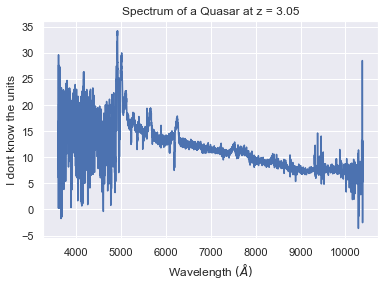

In [6]:
plt.plot(10**perfectSN_dict['WAVE'][364], perfectSN_dict['FLUX'][364])
plt.title('Spectrum of a Quasar at z = 3.05')
plt.xlabel('Wavelength $(\AA)$')
plt.ylabel('I dont know the units')


Text(0, 0.5, 'I dont know the units')

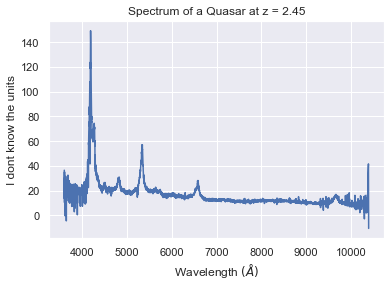

In [7]:
plt.plot(10**perfectSN_dict['WAVE'][649], perfectSN_dict['FLUX'][649])
plt.title('Spectrum of a Quasar at z = 2.45')
plt.xlabel('Wavelength $(\AA)$')
plt.ylabel('I dont know the units')

In [8]:
perfectSN_dict.keys()

dict_keys(['NOISE', 'FLUX', 'WAVE', 'IVAR', 'REDSHIFT', 'CLASS'])

In [9]:
x0 = noise_model(perfectSN_dict, 0, 0.0)
x1 = noise_model(perfectSN_dict, 1, 0.0)
x2 = noise_model(perfectSN_dict, 2, 0.0)
x3 = noise_model(perfectSN_dict, 3, 0.0)
x4 = noise_model(perfectSN_dict, 4, 0.0)
x5 = noise_model(perfectSN_dict, 5, 0.0)
x6 = noise_model(perfectSN_dict, 6, 0.0)
x7 = noise_model(perfectSN_dict, 7, 0.0)
x8 = noise_model(perfectSN_dict, 8, 0.0)
x9 = noise_model(perfectSN_dict, 9, 0.0)
x10 = noise_model(perfectSN_dict, 10, 0.0)
x11 = noise_model(perfectSN_dict, 11, 0.0)
x12 = noise_model(perfectSN_dict, 12, 0.0)
x13 = noise_model(perfectSN_dict, 13, 0.0)
x14 = noise_model(perfectSN_dict, 14, 0.0)
x15 = noise_model(perfectSN_dict, 15, 0.0)
x16 = noise_model(perfectSN_dict, 16, 0.0)
x17 = noise_model(perfectSN_dict, 17, 0.0)
x18 = noise_model(perfectSN_dict, 18, 0.0)
x19 = noise_model(perfectSN_dict, 19, 0.0)
x20 = noise_model(perfectSN_dict, 20, 0.0)
x21 = noise_model(perfectSN_dict, 21, 0.0)
x22 = noise_model(perfectSN_dict, 22, 0.0)
x23 = noise_model(perfectSN_dict, 23, 0.0)
x24 = noise_model(perfectSN_dict, 24, 0.0)

/Users/matt/anaconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide


In [10]:
scaled_var = x0['VAR']
std = scaled_var ** 0.5
noise = x0['NOISE']
wave = x0['WAVE']
flux = x0['FLUX']
deviate = x0['DEVIATE']

[20.012075]


Text(0.5, 1.0, 'Variance ')

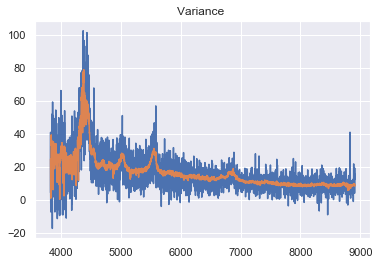

In [11]:
print((noise[856]))
keepidx, = np.where((wave[856] > 3.5818) & (wave[856] < 3.95))

plt.plot(10**wave[856][keepidx], flux[856][keepidx])
plt.plot(10**wave[856][keepidx], flux[856][keepidx] - deviate[856][keepidx])
plt.title('Variance ')

variance, scaled variance, original spectrum, scaled spectrum, std vs 

In [12]:
fake_dict = merg_dict(x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17, x18, x19, x20,\
                     x21, x22, x23, x24)

In [13]:
upd_fake = calc_model_noise(fake_dict)

In [25]:
bal_fake = balancing_noise(upd_fake, var_star_dict['LOW'], 20)

(0, 400)

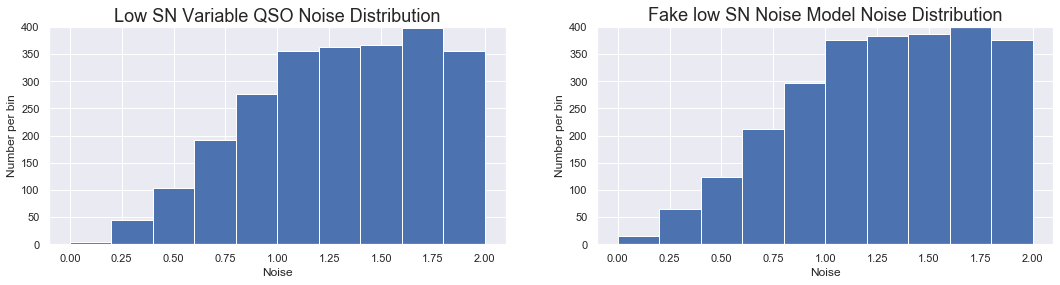

In [26]:
class_labels = np.asarray(var_star_dict['LOW']['CLASS'])
arr_indx = np.where(class_labels == 'QSO')
quasar_noise = np.asarray(var_star_dict['LOW']['NOISE'])
quasar_redshift = np.asarray(var_star_dict['LOW']['REDSHIFT'])


bin_list = [0, .2, .4, .6, .8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.]

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(18, 4))
ax1.hist(quasar_noise[arr_indx], bins = bin_list);
ax1.set_title('Low SN Variable QSO Noise Distribution', fontsize=18);
ax1.set_xlabel('Noise')
ax1.set_ylabel('Number per bin')
ax1.set_ylim(0,400)

ax2.hist(np.asarray(bal_fake['FAKE_NOISE']), bins = bin_list)
ax2.set_title('Fake low SN Noise Model Noise Distribution', fontsize=18);
ax2.set_xlabel('Noise')
ax2.set_ylabel('Number per bin')
ax2.set_ylim(0,400)

(0, 400)

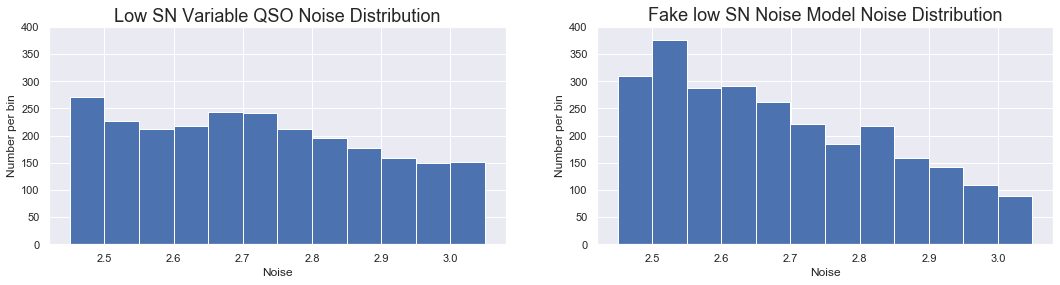

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(18, 4))
ax1.hist(quasar_redshift[arr_indx], bins = 12);
ax1.set_title('Low SN Variable QSO Noise Distribution', fontsize=18);
ax1.set_xlabel('Noise')
ax1.set_ylabel('Number per bin')
ax1.set_ylim(0,400)

ax2.hist(np.asarray(bal_fake['REDSHIFT']), bins = 12)
ax2.set_title('Fake low SN Noise Model Noise Distribution', fontsize=18);
ax2.set_xlabel('Noise')
ax2.set_ylabel('Number per bin')
ax2.set_ylim(0,400)

In [16]:
#redshift_bal_fake = balancing_fake_redshift(bal_fake, var_star_dict, 0)

In [17]:
#redshift_bal_fake.keys()

In [18]:
# class_labels = np.asarray(var_star_dict['LOW']['CLASS'])
# quasar_noise = np.asarray(var_star_dict['LOW']['NOISE'])
# quasar_redshift = np.asarray(var_star_dict['LOW']['REDSHIFT'])

# arr_indx = np.where(class_labels == 'QSO')



# fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(18, 4))
# ax1.hist(quasar_redshift[arr_indx], bins = 10);
# ax1.set_title('Low SN Variable QSO Redshift Distribution', fontsize=18);
# ax1.set_xlabel('Noise')
# ax1.set_ylabel('Number per bin')
# ax1.set_ylim(0,400)

# ax2.hist(redshift_bal_fake['REDSHIFT'], bins = 10)
# ax2.set_title('Fake low SN Noise Model Redshift Distribution', fontsize=18);
# ax2.set_xlabel('Noise')
# ax2.set_ylabel('Number per bin')
# ax2.set_ylim(0,400)

In [19]:
# class_labels = np.asarray(var_star_dict['LOW']['CLASS'])
# quasar_noise = np.asarray(var_star_dict['LOW']['NOISE'])
# arr_indx = np.asarray(np.where(class_labels == 'QSO'))
# quasar_redshift = np.asarray(var_star_dict['LOW']['REDSHIFT'])

# bin_list = [0, .2, .4, .6, .8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.]


# fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(18, 4))
# ax1.hist(quasar_noise[arr_indx], bins = bin_list);
# ax1.set_title('Low SN Variable QSO Noise Distribution', fontsize=18);
# ax1.set_xlabel('Noise')
# ax1.set_ylabel('Number per bin')
# ax1.set_ylim(0,450)

# ax2.hist(np.asarray(bal_fake['FAKE_NOISE']), bins = bin_list)
# ax2.set_title('Fake low SN Noise Model Noise Distribution', fontsize=18);
# ax2.set_xlabel('Noise')
# ax2.set_ylabel('Number per bin')
# ax2.set_ylim(0,450)

In [23]:
save_as_pickled_object(bal_fake, "/Users/matt/Desktop/DESI_Research/DESI_ML/var_CNN/Dictionaries/object_dict/fake_dict")
